# Reducing food wastage, one restaurant at a time..

This is an attempt at determining how busy a restaurant would be during a particular day for few select restaurants in Japan. We will try to model the trend of the customers to give an outlook on how busy the restaurant is going to be for the coming days. Obviously, the main feature that we need to predict here would be the visitor count. Historical data was provided to us through a Kaggle dataset. This kind of analysis would be useful as there is a growing demand from businesses worldwide to have a better estimate of the customer turnouts during a given season. Having an estimate of this would enable them to plan their food supply to minimize the waste and also plan their workload. Customer forecasting will also help business identify what their slow days so that they can plan promotional activities to boost sales on those days. The possibilities are endless.

Let's begin by importing the required modules.

In [1]:
import os  # For iterating through the input files

import numpy as np # Standard Linear Algebra Library
import pandas as pd # Data Processing Library

import datetime as dt # Useful for playing with the date column we have.

from sklearn.preprocessing import LabelEncoder # For Data Prep
from sklearn.preprocessing import MinMaxScaler # For Data Prep

from sklearn.linear_model import SGDRegressor #Regression

from sklearn.metrics import mean_squared_error # For Model Selection

import matplotlib.pyplot as plt # For plotting
import seaborn as sns
import matplotlib.pyplot as plt
import folium

import geopy #For distance calculation

import random
import math

from keras.models import Sequential # Model 
from keras.layers import Dense, LSTM # Model
from keras.layers import Embedding # Model
#from subprocess import check_output


from pylab import rcParams


Using TensorFlow backend.
/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


First, recall that we have some csv files that contain our input data. Let's examine the input we have.

In [3]:

files = os.listdir(os.getcwd())
files_count = 0
print("Input Files:")
for file in files:
    if file.endswith(".csv"):
        files_count+=1
        print(file)
print("\nWe have {} input files in csv format.".format(files_count))

Input Files:
air_store_info.csv
date_info.csv
store_id_relation.csv
hpg_reserve.csv
air_reserve.csv
air_visit_data.csv
sample_submission.csv
hpg_store_info.csv

We have 8 input files in csv format.


Let's begin by storing all of them together. A dictionary is a good choice for this as it will enable us to tag each of these datasets separately.

We will now create a dictionary <code>input_data</code> to store our input.

In [142]:
input_data = {
    'Visit Data': pd.read_csv('air_visit_data.csv'),
    'AIR Store Info': pd.read_csv('air_store_info.csv'),
    'HPG Store Info': pd.read_csv('hpg_store_info.csv'),
    'AIR Reserve Data': pd.read_csv('air_reserve.csv'),
    'HPG Reserve Data': pd.read_csv('hpg_reserve.csv'),
    'Store ID': pd.read_csv('store_id_relation.csv'),
    'Submission': pd.read_csv('sample_submission.csv'),
    'Calendar': pd.read_csv('date_info.csv')
    }

Take a look at the sample information we have for each restaurant and their reservations on a given day.

In [5]:
display(input_data['HPG Reserve Data'].head())

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


So, for each restaurant, each row tells us when a party booked a reservation and when they visited the restaurant. We also have the number of visitors on that day. We should have similar information in our <code> AIR Reserve Data </code> key.

Let's see if the information we have <code> Store ID </code> will be of any use for us to establish a relation between the information we have for a restaurant in both AIR and HPG systems.

In [6]:
display(input_data['Store ID'].head()) # data in id key

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


Perfect! We can defintely use this to join what we have in both AIR and HPG systems. Let's do it step by step. We will being with appending/concatenating the respective store's <code>air_store_id</code> in our dataset from HPG system.

In [7]:
input_data['HPG Reserve Data'] = pd.merge(input_data['HPG Reserve Data'],input_data['Store ID'], how= 'inner', on= 'hpg_store_id')

Let's see how it worked out.

In [8]:
display(input_data['HPG Reserve Data'].head())

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id
0,hpg_878cc70b1abc76f7,2016-01-01 19:00:00,2016-01-01 15:00:00,4,air_db80363d35f10926
1,hpg_878cc70b1abc76f7,2016-01-02 19:00:00,2016-01-02 14:00:00,2,air_db80363d35f10926
2,hpg_878cc70b1abc76f7,2016-01-03 18:00:00,2016-01-02 20:00:00,6,air_db80363d35f10926
3,hpg_878cc70b1abc76f7,2016-01-06 20:00:00,2016-01-04 22:00:00,3,air_db80363d35f10926
4,hpg_878cc70b1abc76f7,2016-01-11 18:00:00,2016-01-11 14:00:00,2,air_db80363d35f10926


Observe that only air_store_id is appended to the already existing data from HPG system.

Now, the main reason we did this is that at the current stage, we have two different datasets about same information on same set of restaurants. We will have to combine these two together into a single dataset to proceed futher. We will have to use <code>air_store_id</code> as that is the identifier which is now common to both the datasets from HPG and AIR systems. 

Let's proceed with combining these two.

Before that we need to make sure that the "schema" of both the datasets that we are joining to be same. The only thing that is causing the mismatch is the <code>hpg_store_id</code> in <code>input_data['HPG Reserve Data']</code>. So, we drop it.

In [9]:
input_data['HPG Reserve Data'].drop('hpg_store_id',  axis=1, inplace=True)

Let's make sure that schema of both dataframes are identical before we perform the append operation.

In [10]:
air_columns = input_data['HPG Reserve Data'].reindex_axis(sorted(input_data['HPG Reserve Data'].columns),axis = 1).columns
hpg_columns = input_data['AIR Reserve Data'].reindex_axis(sorted(input_data['AIR Reserve Data'].columns),axis = 1).columns
assert air_columns.all() == hpg_columns.all()

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  


Assertion passed. Let's append them and store in single dataframe.

In [11]:
input_data['AIR Reserve Data'] = input_data['AIR Reserve Data'].append(input_data['HPG Reserve Data'])

/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


Observe that, for few datasets, we have time part included in our date columns but for few, we don't. Lets make it uniform across all dataframes so that it will be easier for us to perform the training/analysis. 

In [12]:
input_data['Visit Data']['visit_datetime'] = pd.to_datetime(input_data['Visit Data']['visit_date'])

In [13]:
display(input_data['Visit Data'].head())

,air_store_id,visit_date,visitors,visit_datetime
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13
1,air_ba937bf13d40fb24,2016-01-14,32,2016-01-14
2,air_ba937bf13d40fb24,2016-01-15,29,2016-01-15
3,air_ba937bf13d40fb24,2016-01-16,22,2016-01-16
4,air_ba937bf13d40fb24,2016-01-18,6,2016-01-18


In [14]:
input_data['Visit Data']['visit_date']  = input_data['Visit Data']['visit_datetime'].dt.date

In [15]:
display(input_data['Visit Data'].head())

,air_store_id,visit_date,visitors,visit_datetime
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13
1,air_ba937bf13d40fb24,2016-01-14,32,2016-01-14
2,air_ba937bf13d40fb24,2016-01-15,29,2016-01-15
3,air_ba937bf13d40fb24,2016-01-16,22,2016-01-16
4,air_ba937bf13d40fb24,2016-01-18,6,2016-01-18


 We will do the same thing for remaining datasets.

In [16]:
input_data['AIR Reserve Data']['res_visit_datetime'] = pd.to_datetime(input_data['AIR Reserve Data']['visit_datetime'])
input_data['AIR Reserve Data']['reserve_datetime']   = pd.to_datetime(input_data['AIR Reserve Data']['reserve_datetime'])

In [17]:
input_data['AIR Reserve Data']['visit_date'] = input_data['AIR Reserve Data']['res_visit_datetime'].dt.date

In [18]:
input_data['AIR Reserve Data']['reserve_diff'] = \
    input_data['AIR Reserve Data'].apply(lambda r: (r['res_visit_datetime']
                                    - r['reserve_datetime']).days,
                                    axis=1)


Now, let's drop everything else. We keep only visit_data and reserve_diff columns.

In [19]:
input_data['AIR Reserve Data'].drop('visit_datetime',  axis=1, inplace=True)
input_data['AIR Reserve Data'].drop('reserve_datetime',  axis=1, inplace=True)
input_data['AIR Reserve Data'].drop('res_visit_datetime',  axis=1, inplace=True)

In [20]:
avg_reservations = input_data['AIR Reserve Data'].groupby(['air_store_id','visit_date'], 
                                as_index=False).mean().reset_index()

In [21]:
display(avg_reservations.head())

,index,air_store_id,visit_date,reserve_visitors,reserve_diff
0,0,air_00a91d42b08b08d9,2016-01-14,2.0,3.0
1,1,air_00a91d42b08b08d9,2016-01-15,4.0,5.0
2,2,air_00a91d42b08b08d9,2016-01-16,2.0,2.0
3,3,air_00a91d42b08b08d9,2016-01-22,2.0,3.0
4,4,air_00a91d42b08b08d9,2016-01-29,5.0,6.0


In [22]:
sum_reservations = input_data['AIR Reserve Data'].groupby(['air_store_id','visit_date'], 
                                as_index=False).sum().reset_index()

In [23]:
display(sum_reservations.head())

,index,air_store_id,visit_date,reserve_visitors,reserve_diff
0,0,air_00a91d42b08b08d9,2016-01-14,2,3
1,1,air_00a91d42b08b08d9,2016-01-15,4,5
2,2,air_00a91d42b08b08d9,2016-01-16,2,2
3,3,air_00a91d42b08b08d9,2016-01-22,2,3
4,4,air_00a91d42b08b08d9,2016-01-29,5,6


In [24]:
input_data['AIR Reserve Data'] = sum_reservations

Now, we created two different dataframes, one to store the average values and one to store the totals. Average values were created by using <code>mean()</code> over the group by function from pandas.  Totals value was created by using <code>sum()</code> over the group by function from pandas. 

The reason being, to create a unified dataset, we add all the customers but adding the <code>reserve - visit</code> time difference would not make sense to add. To avoid this, we take average of the wait times. This is why we created two different datasets. Now we assign the averaged <code>reserve_diff</code> value to the actual <code>input_data['AIR Reserve Data']</code> dataset.

In [25]:
input_data['AIR Reserve Data'] = input_data['AIR Reserve Data'].drop(['reserve_diff'],axis=1) # Drop it first. 
input_data['AIR Reserve Data'] = input_data['AIR Reserve Data'].drop(['index'],axis=1) # Drop the index column.

Assign <code>reserve_diff</code> from <code>avg_reservations</code> dataset.

In [26]:
input_data['AIR Reserve Data']['reserve_diff'] = avg_reservations['reserve_diff']                            

Let's take a look at the resultant dataset.

In [27]:
display(input_data['AIR Reserve Data'].head())

,air_store_id,visit_date,reserve_visitors,reserve_diff
0,air_00a91d42b08b08d9,2016-01-14,2,3.0
1,air_00a91d42b08b08d9,2016-01-15,4,5.0
2,air_00a91d42b08b08d9,2016-01-16,2,2.0
3,air_00a91d42b08b08d9,2016-01-22,2,3.0
4,air_00a91d42b08b08d9,2016-01-29,5,6.0


Now that we are somewhat 'cleansed' our raw dataset from the csv files, let's take a look the calendar information we have as it is also important for deriving relationships between the visitor turnout and on specific dates.

Let's begin by examining the strucuture of our dataset.

In [28]:
display(input_data['Calendar'].head())

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


Even though the information about holidays is useful, the data at it's current format is not of great use. Let's tweak it a bit to suit of requirements.

First step would be preparing the date columns in appropriate format.

In [29]:
input_data['Calendar']['calendar_date'] = pd.to_datetime(input_data['Calendar']['calendar_date'])
input_data['Calendar']['calendar_date'] = input_data['Calendar']['calendar_date'].dt.date

In [30]:
display(input_data['Calendar'].head())

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [31]:
# Renaming the column to make the merging in the next cell simple.
input_data['Calendar'] = input_data['Calendar'].rename(columns = {'calendar_date' : 'visit_date'})

Now, as a final step, we merge all the above datasets to create one final dataset.

Let's start merging using pandas.merge()

In [32]:
training_df = pd.merge(input_data['Visit Data'], input_data['AIR Reserve Data'],  how='left', on=['air_store_id', 'visit_date'])
training_df = pd.merge(training_df,     input_data['AIR Store Info'],  how='inner', on='air_store_id')
training_df = pd.merge(training_df,     input_data['Calendar'], how='left',  on='visit_date')

Let's take a look at the resultant data frame.

In [33]:
display(training_df.head())

,air_store_id,visit_date,visitors,visit_datetime,reserve_visitors,reserve_diff,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,2016-01-14,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,2016-01-15,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,2016-01-16,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,2016-01-18,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Monday,0


Briefly, these are the columns that we have now in our dataset.

In [34]:
training_df.columns

Index(['air_store_id', 'visit_date', 'visitors', 'visit_datetime',
       'reserve_visitors', 'reserve_diff', 'air_genre_name', 'air_area_name',
       'latitude', 'longitude', 'day_of_week', 'holiday_flg'],
      dtype='object')

<code>air_store_id</code> - Unique identifier for the restaurant<br>
<code>visit_date</code> - Date for which we have the visitor information<br>
<code>visitors</code> - Number of visitors<br>
<code>visit_datetime</code> - Date for which we have the visitor information (in DateTime format)<br>
<code>reserve_visitors</code> - Number of visitors as per the reservation.<br>
<code>reserve_diff</code> - Average duration between reserve time and the actual visit time.<br>
<code>air_genre_name</code> - Cuisine/Genre of the restaurant.<br>
<code>air_area_name</code> - Area in which the restaurant is.<br>
<code>latitude</code> - Location identifier of the restaurant<br>
<code>longitude</code> - Location identifier of the restaurant<br>
<code>day_of_week</code> -  Day of the visit<br>
<code>holiday_flg</code> - Flag to mark a date as a holiday or not.

For the purpose of our benchmark models, we will create a simple regression model without creating too many engineered features.

In [35]:
training_reg = training_df.copy()
training_reg['month'] = training_reg['visit_datetime'].dt.month
training_reg['day']   = training_reg['visit_datetime'].dt.day
training_reg.drop('visit_datetime',axis=1, inplace=True)
display(training_reg.head())

,air_store_id,visit_date,visitors,reserve_visitors,reserve_diff,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,month,day
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0,1,13
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Thursday,0,1,14
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Friday,0,1,15
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Saturday,0,1,16
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Monday,0,1,18


We will now convert/encode our text columns using the One Hot Encoding technique.

In [36]:
categorical_columns = [col for col in ['air_genre_name', 'air_area_name', 'day_of_week']]
for column_of_interest in categorical_columns:
    dummy_series_train = pd.get_dummies(pd.Series(training_reg[column_of_interest]))
    training_reg = pd.concat([training_reg,dummy_series_train], axis = 1)
    # We can drop the column that is now encoded.
    training_reg.drop(column_of_interest, axis = 1, inplace=True)

Now, let's apply log scaling on the response variable.

In [37]:
training_reg['visitors'] = np.log(training_reg['visitors'])

Now that the preparation is complete on the response variable, let's take care of the input variables. As a first step, we will replace the NA values in the columns where we have them.

In [38]:
training_reg.isnull()

,air_store_id,visit_date,visitors,reserve_visitors,reserve_diff,latitude,longitude,holiday_flg,month,day,...,Ōsaka-fu Ōsaka-shi Shinmachi,Ōsaka-fu Ōsaka-shi Ōgimachi,Ōsaka-fu Ōsaka-shi Ōhiraki,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [39]:
training_reg.fillna(0, inplace = True)

Next up are the rest of the input variables which needs some scaling to bring them into a uniform format.

In [40]:
imp_columns_train = training_reg[['air_store_id','visit_date','visitors']]
# Let's drop the above two columns till we perform the scaling on both training and testing datasets.
training_reg.drop(['air_store_id','visit_date','visitors'],axis = 1, inplace = True)
#Lets store the column names in seperate variables
training_columns = training_reg.columns
#Let's start with the actual scaling.
minmax_scaler = MinMaxScaler() # We are going to scale to the default range of (0,1)
minmax_scaler.fit(training_reg)
scaled_training_df = pd.DataFrame(minmax_scaler.transform(training_reg), columns=training_columns)

Let's append back the previously dropped columns.

In [41]:
scaled_training_df['air_store_id'] = imp_columns_train['air_store_id']
scaled_training_df['visit_date'] = imp_columns_train['visit_date']
scaled_training_df['visitors'] = imp_columns_train['visitors']

In [42]:
reg_df = scaled_training_df.copy()

In [43]:
#Converting columns which are not in numerical format into a more suitable way.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(reg_df['air_store_id'])
reg_df['store_id'] = le.transform(reg_df['air_store_id'])
reg_df['visit_date']=reg_df['visit_date'].map(dt.datetime.toordinal)
reg_df.drop('air_store_id', axis = 1 , inplace = True)
reg_df.head()

,reserve_visitors,reserve_diff,latitude,longitude,holiday_flg,month,day,Asian,Bar/Cocktail,Cafe/Sweets,...,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,visit_date,visitors,store_id
0,0.0,0.0,0.226309,0.6788,0.0,0.0,0.400000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,735976,3.218876,603
1,0.0,0.0,0.226309,0.6788,0.0,0.0,0.433333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,735977,3.465736,603
2,0.0,0.0,0.226309,0.6788,0.0,0.0,0.466667,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,735978,3.367296,603
3,0.0,0.0,0.226309,0.6788,0.0,0.0,0.500000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,735979,3.091042,603
4,0.0,0.0,0.226309,0.6788,0.0,0.0,0.566667,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,735981,1.791759,603


In [44]:
total_records = reg_df.shape[0]
train_size = math.floor(total_records * 0.7)
test_size = total_records - train_size
visitors_train = reg_df['visitors'][:train_size]
visitors_test = reg_df['visitors'][train_size:]
reg_df.drop('visitors', axis = 1, inplace = True)
data_train = reg_df[:train_size]
data_test = reg_df[train_size:]
from sklearn.linear_model import LinearRegression
lrg = LinearRegression()
lrg.fit(data_train,visitors_train)
visitors_predict = lrg.predict(data_test)
rmse_linear_reg = mean_squared_error(visitors_test,visitors_predict)
print(rmse_linear_reg)

99579467478.8


Clearly, this is not a good enough value for a metric that is a form of loss function, we can observe from the above implementation that the most of the special features like the co-ordinate values were not explored properly. And they were treated just like any other feature even though they are peculiarly different than the others as they don't actually follow the ordinality rule.

We can try going through the data in a more thorough approach to see if we can engineer few new features from the raw dataset that might improve the model by minimzing the loss function.

# EDA

Let's quickly view the original data we had before preparing it for the regression model.

In [45]:
display(training_df.head())

,air_store_id,visit_date,visitors,visit_datetime,reserve_visitors,reserve_diff,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,2016-01-14,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,2016-01-15,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,2016-01-16,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,2016-01-18,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Monday,0


We will do some quick plots to see the relation between key features like genre, area, days to the visitor turnout

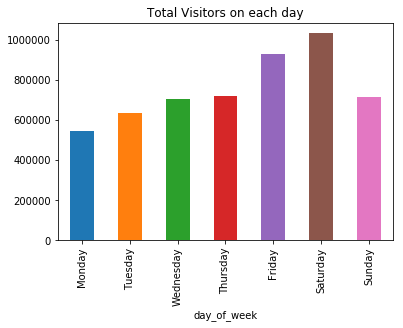

In [46]:
visitors_by_day = training_df.groupby('day_of_week')['visitors'].sum()
visitors_by_day_df = visitors_by_day.to_frame()
visitors_by_day_df['day_of_week'] = visitors_by_day.index
visitors_by_day_df['index'] = np.NaN
visitors_by_day_df.loc['Monday','index'] = 1
visitors_by_day_df.loc['Tuesday','index'] = 2
visitors_by_day_df.loc['Wednesday','index'] = 3
visitors_by_day_df.loc['Thursday','index'] = 4
visitors_by_day_df.loc['Friday','index'] = 5
visitors_by_day_df.loc['Saturday','index'] = 6
visitors_by_day_df.loc['Sunday','index'] = 7
visitors_by_day_df.sort_values(['index'], ascending = True,inplace = True)
visitors_by_day_df['visitors'].plot(kind='bar',title = 'Total Visitors on each day')
plt.show()

There is no surprise here that there are more number of visitors during the weekends than the weekdays and lowest number of visitors on Monday. 

Let's also see the significance of the holiday flag. It will help us in determining if we should keep it or not.

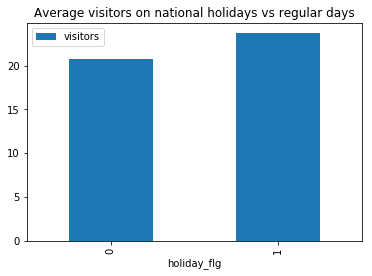

In [47]:
mean_by_holidays = training_df.groupby('holiday_flg')['visitors'].mean()
mean_by_holidays = mean_by_holidays.to_frame()
mean_by_holidays.plot(kind='bar',title = 'Average visitors on national holidays vs regular days')
plt.show()

There is really not much difference between the average visitors on a holiday vs regular day. So this feature, as it stands, doesn't hold that much of a value. But it is a bit premature to arrive at this conclusion. Let's split the dataset and analyse them individually. Then we can arrive at a comprehensive conclusion.

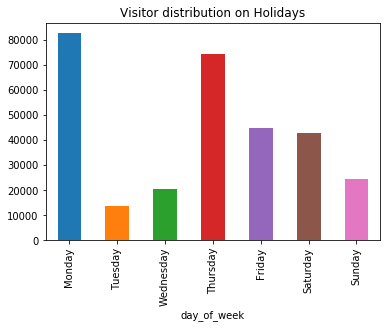

In [48]:
#Rows with records pertaining to holidays
holiday_data = training_df[training_df['holiday_flg'] == 1]
holiday_data = holiday_data.groupby('day_of_week')['visitors'].sum()
holiday_data = holiday_data.to_frame()
holiday_data['day_of_week'] = holiday_data.index
holiday_data['index'] = np.NaN
holiday_data.loc['Monday','index'] = 1
holiday_data.loc['Tuesday','index'] = 2
holiday_data.loc['Wednesday','index'] = 3
holiday_data.loc['Thursday','index'] = 4
holiday_data.loc['Friday','index'] = 5
holiday_data.loc['Saturday','index'] = 6
holiday_data.loc['Sunday','index'] = 7
holiday_data.sort_values(['index'], ascending = True,inplace = True)
holiday_data['visitors'].plot(kind='bar', title = 'Visitor distribution on Holidays')
plt.show()

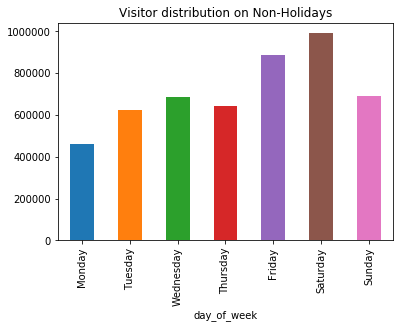

In [49]:
#Rows with records pertaining to non-holidays
non_holiday_data = training_df[training_df['holiday_flg'] == 0]
non_holiday_data = non_holiday_data.groupby('day_of_week')['visitors'].sum()
non_holiday_data = non_holiday_data.to_frame()
non_holiday_data['day_of_week'] = non_holiday_data.index
non_holiday_data['index'] = np.NaN
non_holiday_data.loc['Monday','index'] = 1
non_holiday_data.loc['Tuesday','index'] = 2
non_holiday_data.loc['Wednesday','index'] = 3
non_holiday_data.loc['Thursday','index'] = 4
non_holiday_data.loc['Friday','index'] = 5
non_holiday_data.loc['Saturday','index'] = 6
non_holiday_data.loc['Sunday','index'] = 7
non_holiday_data.sort_values(['index'], ascending = True,inplace = True)
non_holiday_data['visitors'].plot(kind='bar', title = 'Visitor distribution on Non-Holidays')
plt.show()

As we can see, the distribution is clearly different between holiday records and non-holiday records. So it is evident that holiday_flg holds some sort of value to this dataset. So it is better that we keep it.

Now, let's check the actual visitor distribution over the time without any additional/conditional grouping.

<Figure size 2160x288 with 0 Axes>

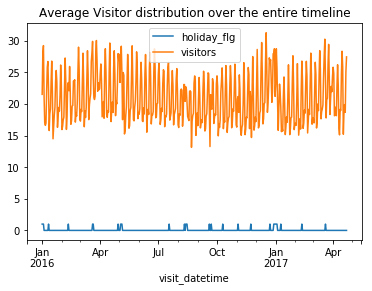

In [50]:
visitors_data = training_df.groupby(['visit_datetime'])[['holiday_flg','visitors']].mean()
#visitors_data = training_df.groupby(['visit_datetime'])['visitors'].mean()
fig = plt.figure()
fig.set_size_inches(30, fig.get_figheight(), forward=True)
visitors_data.plot(title = 'Average Visitor distribution over the entire timeline',legend = True)
#plt.figure(figsize=(200,10))
plt.show()

There is a clear case of seasonality going on over here. We can see that the spikes are very regular and this might be an indication of the pattern discussed above where we have lesser visitors on weekends when compared to weekdays. 

<Figure size 2160x288 with 0 Axes>

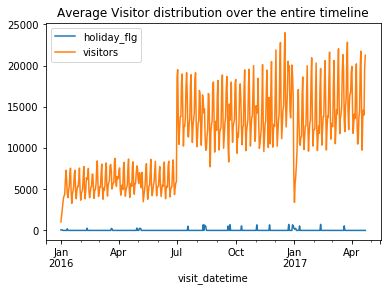

In [51]:
total_visitors_data = training_df.groupby(['visit_datetime'])[['holiday_flg','visitors']].sum()
#visitors_data = training_df.groupby(['visit_datetime'])['visitors'].mean()
fig = plt.figure()
fig.set_size_inches(30, fig.get_figheight(), forward=True)
total_visitors_data.plot(title = 'Average Visitor distribution over the entire timeline',legend = True)
#plt.figure(figsize=(200,10))
plt.show()

It is also interesting to see that we have an almost sudden spike around July, 2016 and there was steady increase of visitors from there. Let's try to find the reason for it.

First, we will check if there were any new genre restaurants that opened during that time frame in any area. We don't need any fancy viz for this :) Just a simple group by on the pandas dataframe would do the job.

In [52]:
training_df_new_genre = training_df.groupby('air_genre_name')['visit_date'].min()
display(training_df_new_genre)

air_genre_name
Asian                           2016-05-01
Bar/Cocktail                    2016-01-01
Cafe/Sweets                     2016-01-01
Creative cuisine                2016-01-01
Dining bar                      2016-01-01
International cuisine           2016-07-01
Italian/French                  2016-01-01
Izakaya                         2016-01-01
Japanese food                   2016-01-01
Karaoke/Party                   2016-07-01
Okonomiyaki/Monja/Teppanyaki    2016-01-02
Other                           2016-01-01
Western food                    2016-01-01
Yakiniku/Korean food            2016-01-02
Name: visit_date, dtype: object

As we can observe, there are some genres which had few restaurants whose data was available to use from July 2016 and that might be one of the reasons for the spike. Let us also check the same thing but on a more granular level.

In [53]:
training_df_new_restaurant = training_df.groupby('air_store_id')['visit_date'].min().to_frame()
training_df_new_restaurant.reset_index(inplace=True)
display(training_df_new_restaurant.head())

,air_store_id,visit_date
0,air_00a91d42b08b08d9,2016-07-01
1,air_0164b9927d20bcc3,2016-10-03
2,air_0241aa3964b7f861,2016-01-03
3,air_0328696196e46f18,2016-07-03
4,air_034a3d5b40d5b1b1,2016-07-01


In the above dataframe, we have each store and the day when their data was first available for us. Now we can aggregate this to construct a more concrete view.

In [54]:
training_df_new_restaurant_counts = training_df_new_restaurant.groupby('visit_date')['air_store_id'].count().to_frame()
training_df_new_restaurant_counts.reset_index(inplace=True)
display(training_df_new_restaurant_counts.sort_values(by='air_store_id', ascending = False).head())

,visit_date,air_store_id
31,2016-07-01,454
3,2016-01-04,81
4,2016-01-05,76
0,2016-01-01,48
1,2016-01-02,31


This is further evidence that we have more number of restaurants that had their data available to us starting from July,2016. We see that we have around 450 restaurants who had their first entry in the database on July 1, 2016. 

As we now know that genre was a minute factor for the spike on July, 2016, let's check if the genre of the restaurant has any actual impact on the visitor counts. If the distribution looks similar for all the different values in the <code>air_genre_name</code> column, we might drop it without any problem. 

Let's check it out now. We can plot a facet plot to see the distributions for all the involved genres. This will help us in quickly comparing the effect of genre on the visitor turnouts.

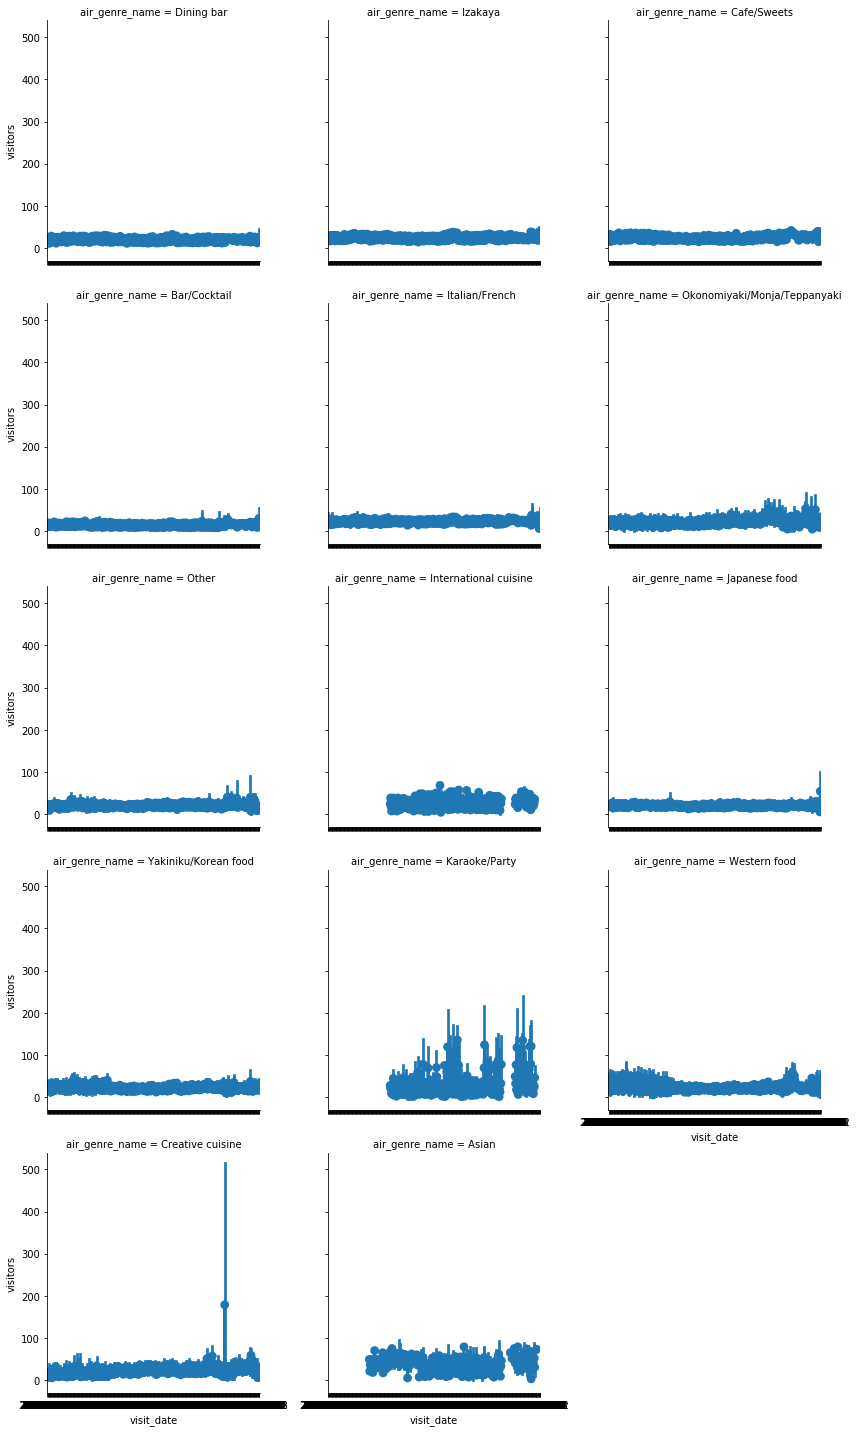

In [55]:
sns.factorplot(data=training_df, x="visit_date", y="visitors", col="air_genre_name", col_wrap = 3,title = 'Visitor Distribution for each Genre/Cuisine')
plt.show()

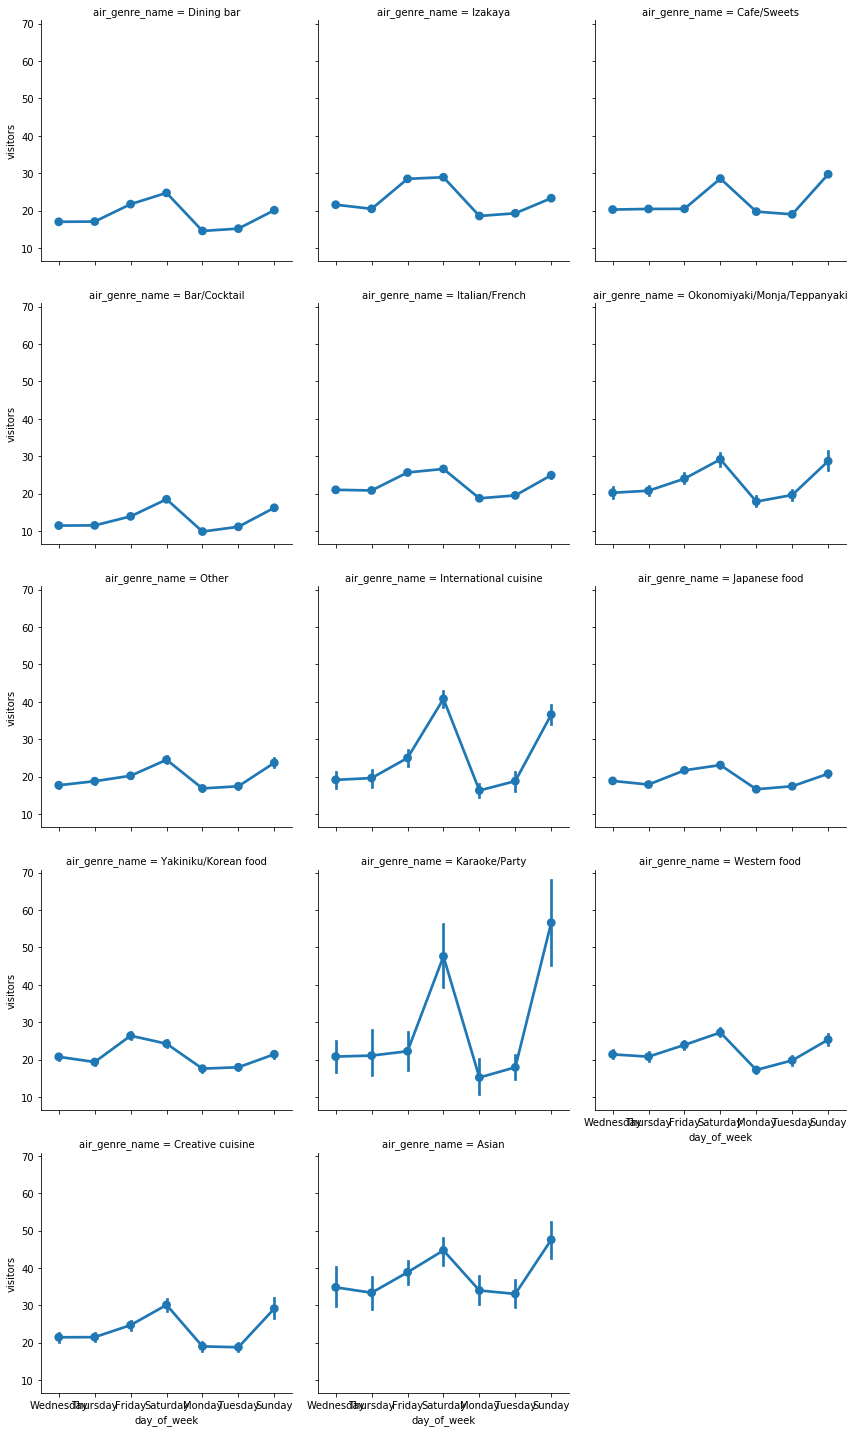

In [56]:
sns.factorplot(data=training_df, x="day_of_week", y="visitors", col="air_genre_name", col_wrap = 3
               ,title = 'Visitor Distribution for each Genre/Cuisine'
              )
plt.show()

Even though the first few genre's have similar distribution, there are indeed few genres that hold some distinct pattern on their visitor turnouts. So it would be better that we keep that column as well.

In the second factorplot, we can see that irrespective of the genre, all of them attract more crowds during the weekend. It should not be any surprise.

With that in mind, let's proceed to check on the one of most interesting aspect in our dataset. The location.

We will modify our dataframe to just have the location and cuisine type in our data for initial analysis.

In [57]:
training_df_loc = training_df.groupby(['air_store_id','latitude','longitude','air_genre_name'])['visitors'].mean()
training_df_loc = training_df_loc.to_frame()
training_df_loc.reset_index(inplace=True)
mean_visitors = training_df_loc['visitors'].mean()
total_genres = (training_df_loc['air_genre_name']).nunique()
display(training_df_loc.head())

,air_store_id,latitude,longitude,air_genre_name,visitors
0,air_00a91d42b08b08d9,35.694003,139.753595,Italian/French,26.081897
1,air_0164b9927d20bcc3,35.658068,139.751599,Italian/French,9.248322
2,air_0241aa3964b7f861,35.712607,139.779996,Izakaya,9.896465
3,air_0328696196e46f18,34.701279,135.528090,Dining bar,7.939655
4,air_034a3d5b40d5b1b1,34.692337,135.472229,Cafe/Sweets,14.828685


So, we no have consolidated our dataset based on the location. We will use the folium library to plot geospatial data. Before that, we will create a simple color table which will serve as a legend for our chart down below.

In [58]:
#color_gradients = ['#fff5cc','#fff0b3','#ffeb99','#ffeb99','#ffeb99','#ffdb4d','#ffd633','#ffd11a','#ffcc00',' #e6b800']
color_gradients = ['#ccffcc','#66ff66','#1aff1a','#85e085','#2eb82e','#ffbb33','#e69900','#ff8533','#cc5200',' #e60000']
color_df = pd.DataFrame(data = {'ID':[1,2,3,4,5,6,7,8,9,10],'Color':color_gradients})

Let's quickly examine our <code>visitors</code> column.

In [59]:
training_df_loc['visitors'].describe()

count    829.000000
mean      21.203887
std       11.774992
min        1.187500
25%       11.812010
50%       19.183406
75%       28.645161
max      115.470588
Name: visitors, dtype: float64

Let's divide the visitors into few categories.

In [60]:

japan_map = folium.Map(location=[36.2048, 138.2529], zoom_start = 5.5,tiles="CartoDB dark_matter")
for index, row in training_df_loc.iterrows():
    visitors_ = row['visitors']
    radius = min(math.ceil(visitors_/10),10)
    #print(radius)
    color_code = color_df[color_df['ID'] == radius]['Color'].iloc[0]
    color = str(color_code)
    #if visitors_ > mean_visitors:
    #    color = "#ffb900"
    #else:
    #    color = "#53e83c"
    folium.CircleMarker(location = (row['latitude'],row['longitude']),
                       radius = radius,
                       fill = False,
                       color = color).add_to(japan_map)
japan_map

From our <code>color_df</code> table, greener shades represent less average visitors and red/orange shades represent more average visitors. As per the visualization above, we have few restaurants where we have more than average visitors and rest of the locations have relatively less visitors over the time.

Also, as we can observe, wherever we have restaurants with higher than average visitors (let's call this 'influencer'), we often have few other restaurants in that surrounding areas which also have higher than average visitors but lesser than the influencer. 

Let's identify these 'influencers'. We will begin by identifying the max visitors in each genre. Then, we will check which restaurant had these max visitors for that particular genre and classify it as an 'influencer'

In [61]:
#training_df_loc.head()
training_df_loc['max_visitors_genre'] = training_df_loc.groupby('air_genre_name')['visitors'].transform(max)
training_df_loc['is_influencer'] = training_df_loc['visitors'] == training_df_loc['max_visitors_genre']
training_df_loc.head()

,air_store_id,latitude,longitude,air_genre_name,visitors,max_visitors_genre,is_influencer
0,air_00a91d42b08b08d9,35.694003,139.753595,Italian/French,26.081897,82.200000,False
1,air_0164b9927d20bcc3,35.658068,139.751599,Italian/French,9.248322,82.200000,False
2,air_0241aa3964b7f861,35.712607,139.779996,Izakaya,9.896465,63.000000,False
3,air_0328696196e46f18,34.701279,135.528090,Dining bar,7.939655,42.519481,False
4,air_034a3d5b40d5b1b1,34.692337,135.472229,Cafe/Sweets,14.828685,76.457143,False


In [62]:
training_df_loc[training_df_loc['is_influencer'] == True]

,air_store_id,latitude,longitude,air_genre_name,visitors,max_visitors_genre,is_influencer
71,air_1c0b150f9e696a5f,35.661777,139.704051,Okonomiyaki/Monja/Teppanyaki,115.470588,115.470588,True
103,air_258dc112912fc458,35.706657,139.868427,Japanese food,63.550000,63.550000,True
268,air_5afb1cca48ceaa19,35.724823,139.715963,Bar/Cocktail,40.742972,40.742972,True
311,air_64a5d5c1381837af,35.707398,139.663835,Creative cuisine,40.223881,40.223881,True
371,air_7514d90009613cd6,43.055460,141.340956,Karaoke/Party,45.298701,45.298701,True
375,air_764f71040a413d4d,35.661777,139.704051,Asian,46.921811,46.921811,True
420,air_86f7b2109e4abd65,34.676231,135.486059,Dining bar,42.519481,42.519481,True
453,air_900d755ebd2f7bbd,35.672114,139.770825,Italian/French,82.200000,82.200000,True
509,air_9bf595ef095572fb,35.661777,139.704051,International cuisine,26.226804,26.226804,True
510,air_9c6787aa03a45586,35.694003,139.753595,Cafe/Sweets,76.457143,76.457143,True


Above is the list of restaurants that classify as influencers in their genre.

It is also worth exploring the vicinty of other restaurants around the influencer. Let's calculate the distance between a restaurant to the influencer restaurant in it's genre.

We will begin by adding a new column with the latitude and longitude in a <code> (lat, long) </code> format.

In [63]:
training_df_loc['location_co'] = "(" + training_df_loc['latitude'].map(str) + "," + training_df_loc['longitude'].map(str) + ")"
training_df_loc.head()

,air_store_id,latitude,longitude,air_genre_name,visitors,max_visitors_genre,is_influencer,location_co
0,air_00a91d42b08b08d9,35.694003,139.753595,Italian/French,26.081897,82.200000,False,"(35.6940027,139.75359509999998)"
1,air_0164b9927d20bcc3,35.658068,139.751599,Italian/French,9.248322,82.200000,False,"(35.6580681,139.7515992)"
2,air_0241aa3964b7f861,35.712607,139.779996,Izakaya,9.896465,63.000000,False,"(35.712607,139.7799956)"
3,air_0328696196e46f18,34.701279,135.528090,Dining bar,7.939655,42.519481,False,"(34.7012792,135.5280905)"
4,air_034a3d5b40d5b1b1,34.692337,135.472229,Cafe/Sweets,14.828685,76.457143,False,"(34.6923371,135.4722289)"


In [64]:
# For each restaurant, we will fetch the location of the 'influencer' restaurant in it's genre.
for idx,row in training_df_loc.iterrows():
    air_genre = row['air_genre_name']
    max_df = training_df_loc.loc[(training_df_loc['is_influencer'] == True) & (training_df_loc['air_genre_name'] == air_genre)]
    influencer_loc = max_df['location_co'].iloc[0]
    training_df_loc.set_value(idx,'influencer_loc',influencer_loc)
training_df_loc.head()

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


,air_store_id,latitude,longitude,air_genre_name,visitors,max_visitors_genre,is_influencer,location_co,influencer_loc
0,air_00a91d42b08b08d9,35.694003,139.753595,Italian/French,26.081897,82.200000,False,"(35.6940027,139.75359509999998)","(35.6721142,139.7708253)"
1,air_0164b9927d20bcc3,35.658068,139.751599,Italian/French,9.248322,82.200000,False,"(35.6580681,139.7515992)","(35.6721142,139.7708253)"
2,air_0241aa3964b7f861,35.712607,139.779996,Izakaya,9.896465,63.000000,False,"(35.712607,139.7799956)","(34.7108955,137.7259397)"
3,air_0328696196e46f18,34.701279,135.528090,Dining bar,7.939655,42.519481,False,"(34.7012792,135.5280905)","(34.676231099999995,135.48605869999997)"
4,air_034a3d5b40d5b1b1,34.692337,135.472229,Cafe/Sweets,14.828685,76.457143,False,"(34.6923371,135.4722289)","(35.6940027,139.75359509999998)"


Let's verify our new column by quickly checking the influencer restaurants alone. The <code> location_co , influencer_loc </code> columns should be equal for those fancy restaurants.

In [65]:
assert (training_df_loc[training_df_loc['is_influencer'] == True]['location_co'] == training_df_loc[training_df_loc['is_influencer'] == True]['influencer_loc']).all

Assert passed! Those two columns are indeed equal. 

Let's calculate distance between a restaurant and the influencer in it's genre. We will be using geopy module for this.

In [66]:
from geopy import distance
for idx, row in training_df_loc.iterrows():
    distance = geopy.distance.vincenty(row['location_co'], row['influencer_loc']).km
    training_df_loc.set_value(idx,'distance',math.floor(distance))
training_df_loc.head()

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


,air_store_id,latitude,longitude,air_genre_name,visitors,max_visitors_genre,is_influencer,location_co,influencer_loc,distance
0,air_00a91d42b08b08d9,35.694003,139.753595,Italian/French,26.081897,82.200000,False,"(35.6940027,139.75359509999998)","(35.6721142,139.7708253)",2.0
1,air_0164b9927d20bcc3,35.658068,139.751599,Italian/French,9.248322,82.200000,False,"(35.6580681,139.7515992)","(35.6721142,139.7708253)",2.0
2,air_0241aa3964b7f861,35.712607,139.779996,Izakaya,9.896465,63.000000,False,"(35.712607,139.7799956)","(34.7108955,137.7259397)",217.0
3,air_0328696196e46f18,34.701279,135.528090,Dining bar,7.939655,42.519481,False,"(34.7012792,135.5280905)","(34.676231099999995,135.48605869999997)",4.0
4,air_034a3d5b40d5b1b1,34.692337,135.472229,Cafe/Sweets,14.828685,76.457143,False,"(34.6923371,135.4722289)","(35.6940027,139.75359509999998)",405.0


Let's plot the number of visitors as the distance to influencer increases for each genre.

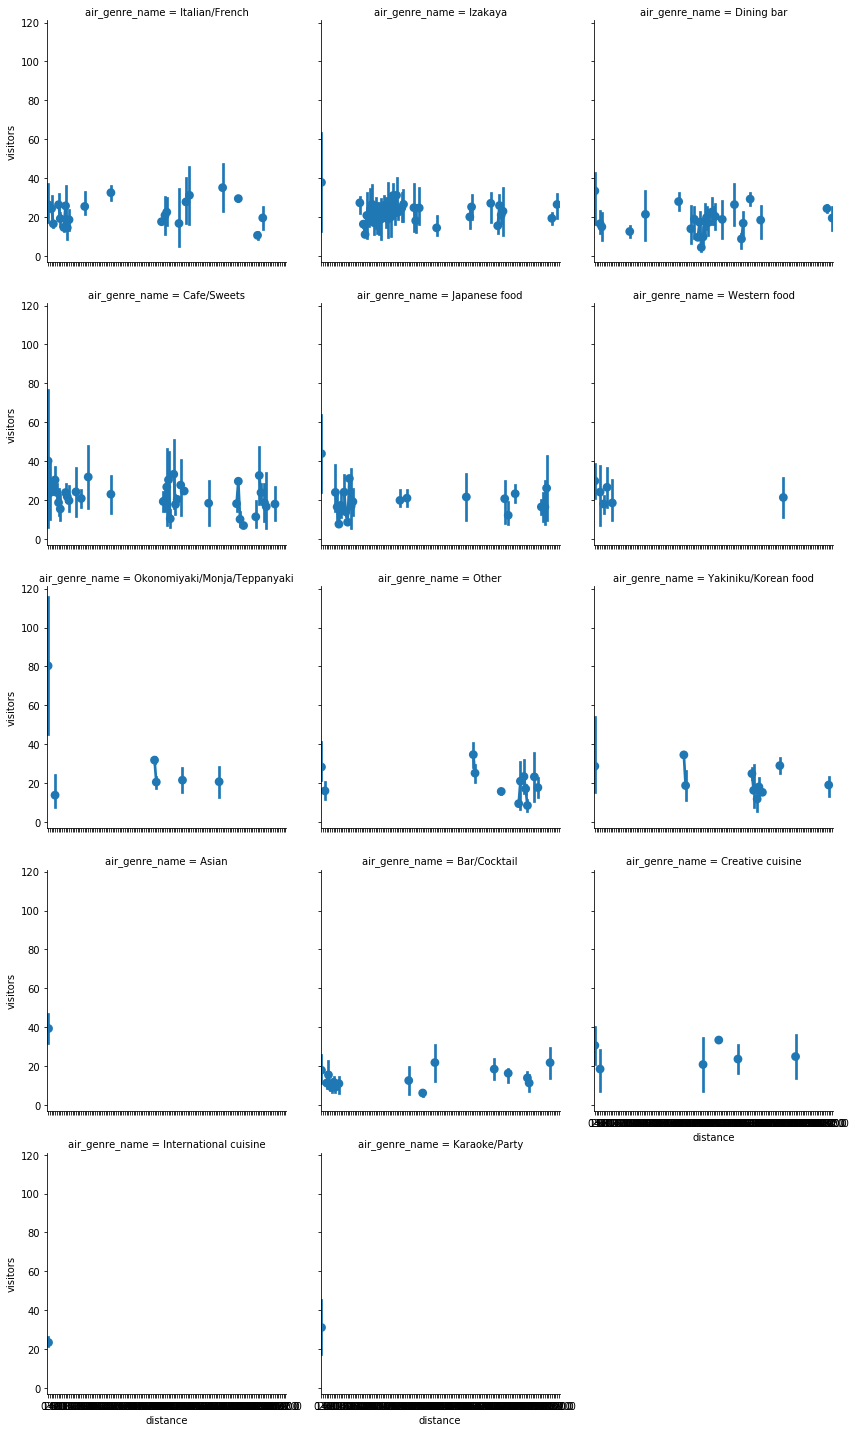

In [67]:
sns.factorplot(data=training_df_loc, x="distance", y="visitors", col="air_genre_name", col_wrap = 3
               ,title = 'Visitor Distribution for each Genre/Cuisine as a factor of Distance')
plt.show()

As per the above observation, there are few genres like Karaoke, International Cuisine, Asian, Western food where most of the restaurants are in the same vicinty. So with this, we can conclude that both genre and location influence the visitor outcome in their own way. So it is best to keep both the columns for our model.

Also, for most of the genres, looks like the users prefer exploring other restaurants in the same vicinty even though they have a fairly well established restaurant nearby.

Just like we found few "influencer" restaurants, let's also figure out few "popular" restaurants. These will be the restaurants that have a few more restaurants in it's close vicinity. 

Essentially, we would be deriving the number of the restaurants around a select restaurant from our data. While it is tempting to use k-means for this, it might not be right approach as we are going to group the restaurants based on their spatial distance. 

First, we need to define a function to calculate the distance between two spatial points. Thankfully, as observed above, we already have <code>geopy.distance.vincenty</code> which works well for this purpose.

Now, we will choose an aribtary distance two define which two restaurants are in a vicinity. Let's go with 5Kms. This means that, if two restaurants are within a radius of 5 Kms, we will consider both to be in the same vicinity.

In [68]:
THRESHOLD_DISTANCE = 5
training_df_loc.head()

,air_store_id,latitude,longitude,air_genre_name,visitors,max_visitors_genre,is_influencer,location_co,influencer_loc,distance
0,air_00a91d42b08b08d9,35.694003,139.753595,Italian/French,26.081897,82.200000,False,"(35.6940027,139.75359509999998)","(35.6721142,139.7708253)",2.0
1,air_0164b9927d20bcc3,35.658068,139.751599,Italian/French,9.248322,82.200000,False,"(35.6580681,139.7515992)","(35.6721142,139.7708253)",2.0
2,air_0241aa3964b7f861,35.712607,139.779996,Izakaya,9.896465,63.000000,False,"(35.712607,139.7799956)","(34.7108955,137.7259397)",217.0
3,air_0328696196e46f18,34.701279,135.528090,Dining bar,7.939655,42.519481,False,"(34.7012792,135.5280905)","(34.676231099999995,135.48605869999997)",4.0
4,air_034a3d5b40d5b1b1,34.692337,135.472229,Cafe/Sweets,14.828685,76.457143,False,"(34.6923371,135.4722289)","(35.6940027,139.75359509999998)",405.0


We will now define a function which will calculate, for each restaurant, the number of restaurants in it's vicinty. 

In [69]:
def return_neighbours(point, data):
    neighbours = 0
    for idx,row in data.iterrows():
        distance = geopy.distance.vincenty(point, row['location_co']).km
        if distance < THRESHOLD_DISTANCE:
            neighbours+=1
    return neighbours
training_df_loc['neighbours'] = None
for idx,row in training_df_loc.iterrows():
    current_restaurant_cord = row['location_co']
    neighbours = return_neighbours(current_restaurant_cord, training_df_loc)
    training_df_loc.set_value(idx,'neighbours',neighbours)
    

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


In [70]:
training_df_loc['neighbours'].describe()
training_df_loc['visitors'].describe()

count    829.000000
mean      21.203887
std       11.774992
min        1.187500
25%       11.812010
50%       19.183406
75%       28.645161
max      115.470588
Name: visitors, dtype: float64

With our new column, we can classify the restaurants based on the total number of restaurants in their surroundings. 

In [71]:
classes = [1,2,3,4,5,6,7]
condition = [
    (training_df_loc['neighbours'] < 50),
    (training_df_loc['neighbours'] < 100) & (training_df_loc['neighbours'] > 50),
    (training_df_loc['neighbours'] < 150) & (training_df_loc['neighbours'] > 100),
    (training_df_loc['neighbours'] < 200) & (training_df_loc['neighbours'] > 150),
    (training_df_loc['neighbours'] < 250) & (training_df_loc['neighbours'] > 200),
    (training_df_loc['neighbours'] < 300) & (training_df_loc['neighbours'] > 250),
    (training_df_loc['neighbours'] > 300)
    ]
training_df_loc['restaurant_vicinty'] = np.select(condition, classes, default='0')
training_df_loc.head()

,air_store_id,latitude,longitude,air_genre_name,visitors,max_visitors_genre,is_influencer,location_co,influencer_loc,distance,neighbours,restaurant_vicinty
0,air_00a91d42b08b08d9,35.694003,139.753595,Italian/French,26.081897,82.200000,False,"(35.6940027,139.75359509999998)","(35.6721142,139.7708253)",2.0,213,5
1,air_0164b9927d20bcc3,35.658068,139.751599,Italian/French,9.248322,82.200000,False,"(35.6580681,139.7515992)","(35.6721142,139.7708253)",2.0,194,4
2,air_0241aa3964b7f861,35.712607,139.779996,Izakaya,9.896465,63.000000,False,"(35.712607,139.7799956)","(34.7108955,137.7259397)",217.0,98,2
3,air_0328696196e46f18,34.701279,135.528090,Dining bar,7.939655,42.519481,False,"(34.7012792,135.5280905)","(34.676231099999995,135.48605869999997)",4.0,60,2
4,air_034a3d5b40d5b1b1,34.692337,135.472229,Cafe/Sweets,14.828685,76.457143,False,"(34.6923371,135.4722289)","(35.6940027,139.75359509999998)",405.0,62,2


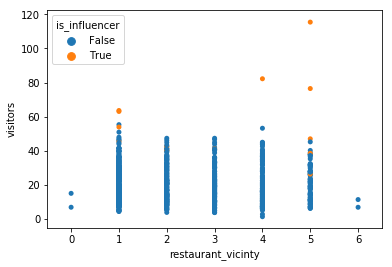

In [72]:
ax = sns.stripplot(x='restaurant_vicinty',y='visitors',data=training_df_loc,hue = 'is_influencer')
plt.show()

Let us also check if there is any information that can be gained by checking if any of the restaurant acts as a sole representative of it's cuisine in it's "vicinity"

In [73]:
def return_same_genre_neighbours(point, data, genre):
    neighbours = 0
    for idx,row in data.iterrows():
        distance = geopy.distance.vincenty(point, row['location_co']).km
        if row['air_genre_name'] == genre and distance < THRESHOLD_DISTANCE:
            neighbours+=1
    return neighbours
training_df_loc['same_genre_neighbours'] = None
for idx,row in training_df_loc.iterrows():
    current_restaurant_cord = row['location_co']
    neighbours = return_same_genre_neighbours(current_restaurant_cord, training_df_loc,row['air_genre_name'])
    training_df_loc.set_value(idx,'same_genre_neighbours',neighbours)

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


In [74]:
training_df_loc['same_genre_neighbours'].max()

48

In [75]:
classes = [0,1,2,3,4,5,6,7,8]
condition = [
    (training_df_loc['same_genre_neighbours'] > 40),
    (training_df_loc['same_genre_neighbours'] > 35) & (training_df_loc['same_genre_neighbours'] < 40),
    (training_df_loc['same_genre_neighbours'] > 30) & (training_df_loc['same_genre_neighbours'] < 35),
    (training_df_loc['same_genre_neighbours'] > 25) & (training_df_loc['same_genre_neighbours'] < 30),
    (training_df_loc['same_genre_neighbours'] > 20) & (training_df_loc['same_genre_neighbours'] < 25),
    (training_df_loc['same_genre_neighbours'] > 15) & (training_df_loc['same_genre_neighbours'] < 20),
    (training_df_loc['same_genre_neighbours'] > 10) & (training_df_loc['same_genre_neighbours'] < 15),
    (training_df_loc['same_genre_neighbours'] > 5)  & (training_df_loc['same_genre_neighbours'] < 10),
    (training_df_loc['same_genre_neighbours'] < 5)
    ]
training_df_loc['restaurant_exclusivity'] = np.select(condition, classes, default='0')
training_df_loc.head()

,air_store_id,latitude,longitude,air_genre_name,visitors,max_visitors_genre,is_influencer,location_co,influencer_loc,distance,neighbours,restaurant_vicinty,same_genre_neighbours,restaurant_exclusivity
0,air_00a91d42b08b08d9,35.694003,139.753595,Italian/French,26.081897,82.200000,False,"(35.6940027,139.75359509999998)","(35.6721142,139.7708253)",2.0,213,5,39,1
1,air_0164b9927d20bcc3,35.658068,139.751599,Italian/French,9.248322,82.200000,False,"(35.6580681,139.7515992)","(35.6721142,139.7708253)",2.0,194,4,42,0
2,air_0241aa3964b7f861,35.712607,139.779996,Izakaya,9.896465,63.000000,False,"(35.712607,139.7799956)","(34.7108955,137.7259397)",217.0,98,2,27,3
3,air_0328696196e46f18,34.701279,135.528090,Dining bar,7.939655,42.519481,False,"(34.7012792,135.5280905)","(34.676231099999995,135.48605869999997)",4.0,60,2,12,6
4,air_034a3d5b40d5b1b1,34.692337,135.472229,Cafe/Sweets,14.828685,76.457143,False,"(34.6923371,135.4722289)","(35.6940027,139.75359509999998)",405.0,62,2,17,5


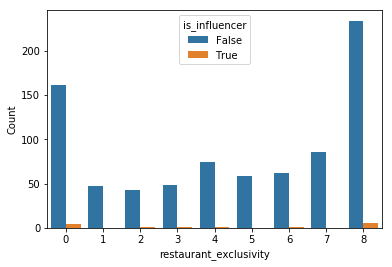

In [76]:
exclusive_restaurants = training_df_loc.groupby(['restaurant_exclusivity','is_influencer']).size()
exclusive_restaurants = exclusive_restaurants.to_frame()
exclusive_restaurants.reset_index(inplace=True)
exclusive_restaurants.columns = ['restaurant_exclusivity','is_influencer','Count']
sns.barplot(x='restaurant_exclusivity', y='Count', hue = 'is_influencer', data = exclusive_restaurants)
plt.show()

Also, we can quickly check how the influencers are positioned spatially and if there is any relation between them

In [77]:

influencer_map = folium.Map(location=[36.2048, 138.2529], zoom_start = 5.5,tiles="CartoDB dark_matter")
for index, row in training_df_loc.iterrows():
    visitors_ = row['visitors']
    radius = min(math.ceil(visitors_/10),10)
    #print(radius)
    if row['is_influencer']:
        color = "#8B0000"
    else:
        color = "#99b433"
    #color_code = color_df[color_df['ID'] == radius]['Color'].iloc[0]
    #color = str(color_code)
    #if visitors_ > mean_visitors:
    #    color = "#ffb900"
    #else:
    #    color = "#53e83c"
    folium.CircleMarker(location = (row['latitude'],row['longitude']),
                       radius = radius,
                       fill = False,
                       color = color).add_to(influencer_map)
influencer_map

Adding image for Github compatibility. (Folium maps are not displayed outside the Jupyter environment)

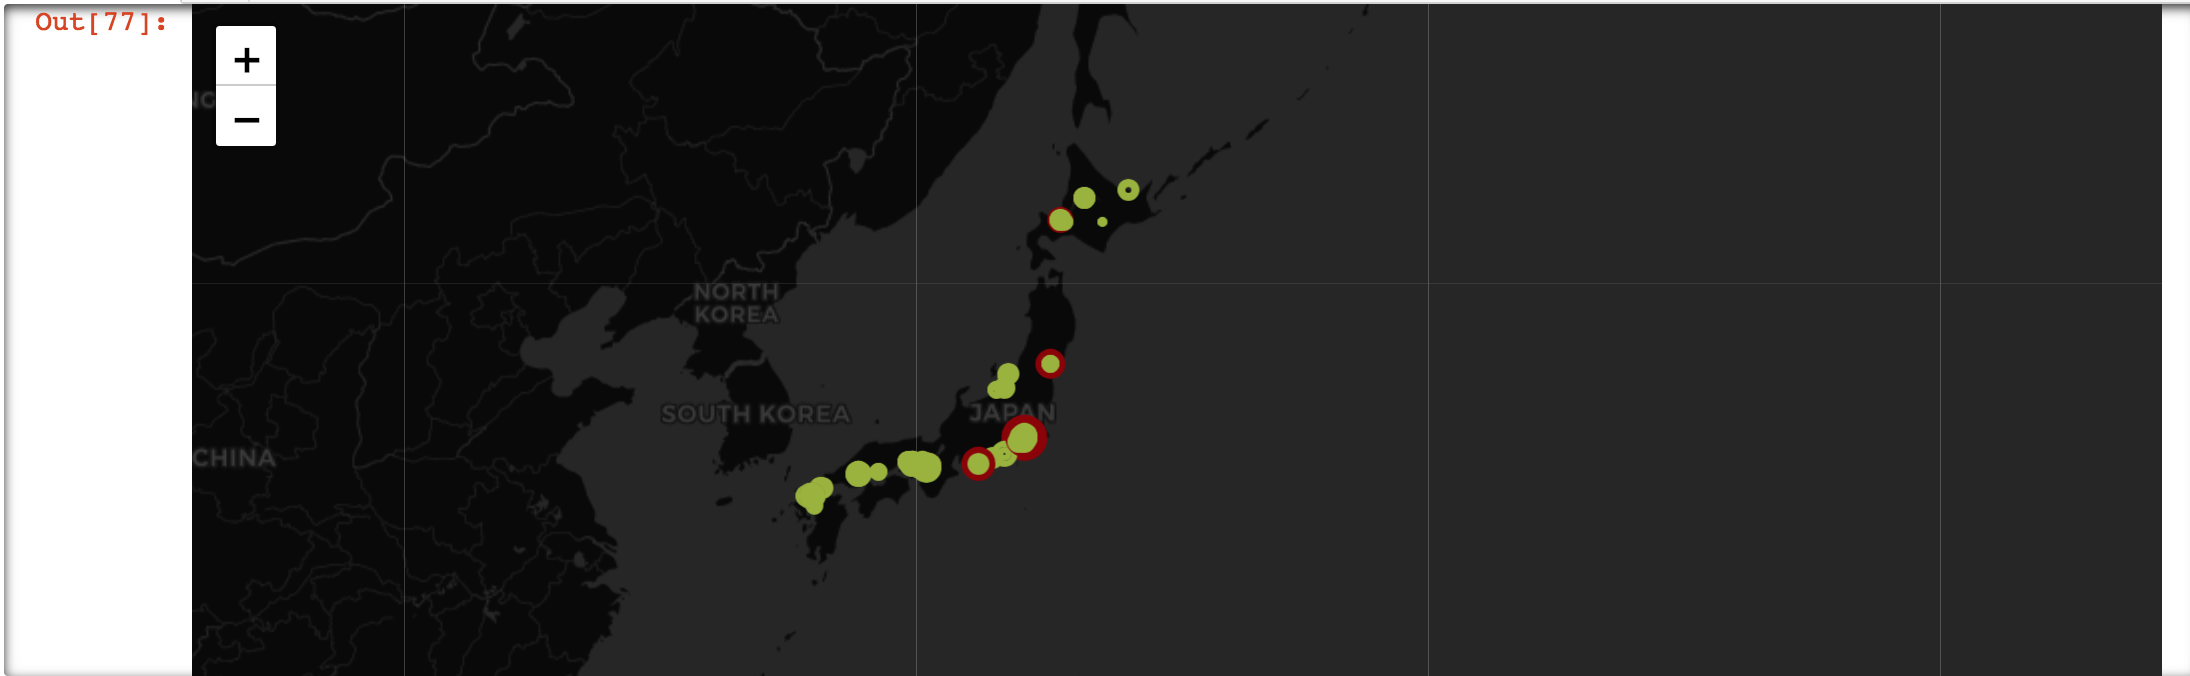

Looks like most of the "influencer" restaurants(red ones) are located on the east coast of Japan. So it is quite clear that the location feature holds significant value in determining the visitor turnouts.

In [78]:
training_df_loc.head()

,air_store_id,latitude,longitude,air_genre_name,visitors,max_visitors_genre,is_influencer,location_co,influencer_loc,distance,neighbours,restaurant_vicinty,same_genre_neighbours,restaurant_exclusivity
0,air_00a91d42b08b08d9,35.694003,139.753595,Italian/French,26.081897,82.200000,False,"(35.6940027,139.75359509999998)","(35.6721142,139.7708253)",2.0,213,5,39,1
1,air_0164b9927d20bcc3,35.658068,139.751599,Italian/French,9.248322,82.200000,False,"(35.6580681,139.7515992)","(35.6721142,139.7708253)",2.0,194,4,42,0
2,air_0241aa3964b7f861,35.712607,139.779996,Izakaya,9.896465,63.000000,False,"(35.712607,139.7799956)","(34.7108955,137.7259397)",217.0,98,2,27,3
3,air_0328696196e46f18,34.701279,135.528090,Dining bar,7.939655,42.519481,False,"(34.7012792,135.5280905)","(34.676231099999995,135.48605869999997)",4.0,60,2,12,6
4,air_034a3d5b40d5b1b1,34.692337,135.472229,Cafe/Sweets,14.828685,76.457143,False,"(34.6923371,135.4722289)","(35.6940027,139.75359509999998)",405.0,62,2,17,5


Let's use the new features created above i.e. Influencer, Popular , vicinity etc to 'complete' our dataset.

In [79]:
training_df_loc_subset = training_df_loc[['air_store_id','is_influencer','distance','restaurant_vicinty','same_genre_neighbours','restaurant_exclusivity']]
training_df_loc_subset.head()

,air_store_id,is_influencer,distance,restaurant_vicinty,same_genre_neighbours,restaurant_exclusivity
0,air_00a91d42b08b08d9,False,2.0,5,39,1
1,air_0164b9927d20bcc3,False,2.0,4,42,0
2,air_0241aa3964b7f861,False,217.0,2,27,3
3,air_0328696196e46f18,False,4.0,2,12,6
4,air_034a3d5b40d5b1b1,False,405.0,2,17,5


In [80]:
training_dataset = training_df.merge(training_df_loc_subset, on='air_store_id')
training_dataset.head()

,air_store_id,visit_date,visitors,visit_datetime,reserve_visitors,reserve_diff,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,is_influencer,distance,restaurant_vicinty,same_genre_neighbours,restaurant_exclusivity
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0,False,403.0,4,21,4
1,air_ba937bf13d40fb24,2016-01-14,32,2016-01-14,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Thursday,0,False,403.0,4,21,4
2,air_ba937bf13d40fb24,2016-01-15,29,2016-01-15,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Friday,0,False,403.0,4,21,4
3,air_ba937bf13d40fb24,2016-01-16,22,2016-01-16,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Saturday,0,False,403.0,4,21,4
4,air_ba937bf13d40fb24,2016-01-18,6,2016-01-18,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Monday,0,False,403.0,4,21,4


Notice that we performed a merge operation on our datasets to 'import' the features that we created in our analysis phase over to the original dataset.

In [81]:
training_dataset['month'] = training_dataset['visit_datetime'].dt.month
training_dataset['day']   = training_dataset['visit_datetime'].dt.day
training_dataset['year']   = training_dataset['visit_datetime'].dt.year
training_dataset.drop('visit_datetime',      axis=1, inplace=True)
training_dataset.head()

,air_store_id,visit_date,visitors,reserve_visitors,reserve_diff,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,is_influencer,distance,restaurant_vicinty,same_genre_neighbours,restaurant_exclusivity,month,day,year
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0,False,403.0,4,21,4,1,13,2016
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Thursday,0,False,403.0,4,21,4,1,14,2016
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Friday,0,False,403.0,4,21,4,1,15,2016
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Saturday,0,False,403.0,4,21,4,1,16,2016
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Monday,0,False,403.0,4,21,4,1,18,2016


In [82]:
categorical_columns = [col for col in ['air_genre_name', 'air_area_name', 'day_of_week']]

In [83]:
for column_of_interest in categorical_columns:
    dummy_series_train = pd.get_dummies(pd.Series(training_dataset[column_of_interest]))
    training_dataset = pd.concat([training_dataset,dummy_series_train], axis = 1)
    # We can drop the column that is now encoded.
    training_dataset.drop(column_of_interest, axis = 1, inplace=True)

In [84]:
training_dataset.head()

,air_store_id,visit_date,visitors,reserve_visitors,reserve_diff,latitude,longitude,holiday_flg,is_influencer,distance,...,Ōsaka-fu Ōsaka-shi Shinmachi,Ōsaka-fu Ōsaka-shi Ōgimachi,Ōsaka-fu Ōsaka-shi Ōhiraki,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,35.658068,139.751599,0,False,403.0,...,0,0,0,0,0,0,0,0,0,1
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,35.658068,139.751599,0,False,403.0,...,0,0,0,0,0,0,0,1,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,35.658068,139.751599,0,False,403.0,...,0,0,0,1,0,0,0,0,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,35.658068,139.751599,0,False,403.0,...,0,0,0,0,0,1,0,0,0,0
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,35.658068,139.751599,0,False,403.0,...,0,0,0,0,1,0,0,0,0,0


Our response variable, 'visitors' is right now in the regular numerical format. To achieve better results and for other well established reasons, let's convert that variable into a logarithmic distribution.

In [85]:
training_dataset['visitors'] = np.log(training_dataset['visitors'])

Now that our premilinary data prep is almost done, let's do one final check to see if we have any NaN values in our dataframe.

In [86]:
training_dataset.isnull()

,air_store_id,visit_date,visitors,reserve_visitors,reserve_diff,latitude,longitude,holiday_flg,is_influencer,distance,...,Ōsaka-fu Ōsaka-shi Shinmachi,Ōsaka-fu Ōsaka-shi Ōgimachi,Ōsaka-fu Ōsaka-shi Ōhiraki,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [87]:
training_dataset.fillna(0, inplace = True) # Let's replace those values of NA with 0 for now.

Now, lets proceed with scaling our dataframes so that we can have all our descriptive columns within the same range. Note that this excludes air_store_id and visit_date columns from our existing dataframes.

In [88]:
training_dataset_copy = training_dataset.copy()
imp_columns_train = training_dataset[['air_store_id','visit_date','visitors']]
# Let's drop the above two columns till we perform the scaling on both training and testing datasets.
training_dataset.drop(['air_store_id','visit_date','visitors'],axis = 1, inplace = True)
#Lets store the column names in seperate variables
training_columns = training_dataset.columns
#Let's start with the actual scaling.
minmax_scaler = MinMaxScaler() # We are going to scale to the default range of (0,1)
minmax_scaler.fit(training_dataset)
scaled_training_dataset = pd.DataFrame(minmax_scaler.transform(training_dataset), columns=training_columns)

In [89]:
#Let's add back the columns that we dropped before scaling our dataset.
scaled_training_dataset['air_store_id'] = imp_columns_train['air_store_id']
scaled_training_dataset['visit_date'] = imp_columns_train['visit_date']
scaled_training_dataset['visitors'] = imp_columns_train['visitors']
scaled_training_dataset.head()

,reserve_visitors,reserve_diff,latitude,longitude,holiday_flg,is_influencer,distance,restaurant_vicinty,same_genre_neighbours,restaurant_exclusivity,...,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,air_store_id,visit_date,visitors
0,0.0,0.0,0.226309,0.6788,0.0,0.0,0.344444,0.666667,0.413043,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,air_ba937bf13d40fb24,2016-01-13,3.218876
1,0.0,0.0,0.226309,0.6788,0.0,0.0,0.344444,0.666667,0.413043,0.5,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,air_ba937bf13d40fb24,2016-01-14,3.465736
2,0.0,0.0,0.226309,0.6788,0.0,0.0,0.344444,0.666667,0.413043,0.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,air_ba937bf13d40fb24,2016-01-15,3.367296
3,0.0,0.0,0.226309,0.6788,0.0,0.0,0.344444,0.666667,0.413043,0.5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,air_ba937bf13d40fb24,2016-01-16,3.091042
4,0.0,0.0,0.226309,0.6788,0.0,0.0,0.344444,0.666667,0.413043,0.5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,air_ba937bf13d40fb24,2016-01-18,1.791759


We will first apply a Random Forest Regression model to our current complete dataset. Before doing that, we can simplify our dataset by removing the air_store_id column as we have good enough indicators of the restaurants now which are a more accurate representation of it's features. This will enable us to not to deal with the text nature of the air_store_id column

In [90]:
rf_scaled_training = scaled_training_dataset.drop('air_store_id',axis=1,inplace=False)

In [91]:
rf_scaled_training.head()

,reserve_visitors,reserve_diff,latitude,longitude,holiday_flg,is_influencer,distance,restaurant_vicinty,same_genre_neighbours,restaurant_exclusivity,...,Ōsaka-fu Ōsaka-shi Ōhiraki,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,visit_date,visitors
0,0.0,0.0,0.226309,0.6788,0.0,0.0,0.344444,0.666667,0.413043,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2016-01-13,3.218876
1,0.0,0.0,0.226309,0.6788,0.0,0.0,0.344444,0.666667,0.413043,0.5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2016-01-14,3.465736
2,0.0,0.0,0.226309,0.6788,0.0,0.0,0.344444,0.666667,0.413043,0.5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-15,3.367296
3,0.0,0.0,0.226309,0.6788,0.0,0.0,0.344444,0.666667,0.413043,0.5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2016-01-16,3.091042
4,0.0,0.0,0.226309,0.6788,0.0,0.0,0.344444,0.666667,0.413043,0.5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2016-01-18,1.791759


In [92]:
train_size = int(len(rf_scaled_training) * 0.7)
test_size = len(rf_scaled_training) - train_size
visitors = rf_scaled_training['visitors'].copy()
rf_scaled_training.drop('visitors',axis =1 , inplace = True)
visitors = visitors.to_frame(name='visitors')
rf_scaled_training.drop(['visit_date'],axis =1 , inplace = True)
x_train,x_test = rf_scaled_training[:train_size],rf_scaled_training[train_size:]
y_train,y_test = visitors[:train_size],visitors[train_size:]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(176475, 137) (176475, 1) (75633, 137) (75633, 1)


And for the choice of our model, as the data has a high dimensionality, we will use Random Forest Regressor.

In [93]:
from sklearn.ensemble import RandomForestRegressor
rf_train_X = x_train.copy()#rain_X.reshape(train_X.shape[0], train_X.shape[2])
rf_test_X = x_test.copy()#test_X.reshape(test_X.shape[0],test_X.shape[2])
rf_train_y = y_train.copy()#train_y
rf_test_y = y_test.copy()

#Initializing AdaBoostRegressor
rf_model=RandomForestRegressor()
rf_model.fit(rf_train_X,rf_train_y)
# Make predictions:
#y_pred_rf = [rf_test_X.shape[0]]
y_pred_rf = rf_model.predict(rf_test_X)

y_pred_rf=np.array(y_pred_rf)
y_pred_rf=y_pred_rf.reshape(y_pred_rf.shape[0],1)

rmsle = mean_squared_error(rf_test_y, y_pred_rf)
print('Random Forest Regrssion Model - MSE: %.3f' % rmsle)


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Random Forest Regrssion Model - MSE: 1.092


Let's drop the latitude and longitude columns from the dataset as we already captured the effect of the location in various other engineered features.

After dropping the lat and long columns, we will again build our model to check the accuracy on the test set.


In [94]:
#let's use the acronym 'twl' to represent training data without latitude and longitude.
twl = rf_scaled_training.copy()
twl.drop(['latitude','longitude'], axis =1 , inplace = True)
x_train_twl,x_test_twl = twl[:train_size],twl[train_size:]
y_train_twl,y_test_twl = visitors[:train_size],visitors[train_size:]
rf_model_twl = RandomForestRegressor()
rf_model_twl.fit(x_train_twl, y_train_twl)
y_pred_twl = [x_test_twl.shape[0]]
y_pred_twl = rf_model_twl.predict(x_test_twl)
print(mean_squared_error(np.array(y_test_twl['visitors']), y_pred_twl))

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


1.07620740654


In [95]:
tdc = scaled_training_dataset.copy()

In [96]:
tdc.drop(['latitude','longitude'], axis =1 , inplace = True)
(tdc.head())

,reserve_visitors,reserve_diff,holiday_flg,is_influencer,distance,restaurant_vicinty,same_genre_neighbours,restaurant_exclusivity,month,day,...,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,air_store_id,visit_date,visitors
0,0.0,0.0,0.0,0.0,0.344444,0.666667,0.413043,0.5,0.0,0.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,air_ba937bf13d40fb24,2016-01-13,3.218876
1,0.0,0.0,0.0,0.0,0.344444,0.666667,0.413043,0.5,0.0,0.433333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,air_ba937bf13d40fb24,2016-01-14,3.465736
2,0.0,0.0,0.0,0.0,0.344444,0.666667,0.413043,0.5,0.0,0.466667,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,air_ba937bf13d40fb24,2016-01-15,3.367296
3,0.0,0.0,0.0,0.0,0.344444,0.666667,0.413043,0.5,0.0,0.500000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,air_ba937bf13d40fb24,2016-01-16,3.091042
4,0.0,0.0,0.0,0.0,0.344444,0.666667,0.413043,0.5,0.0,0.566667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,air_ba937bf13d40fb24,2016-01-18,1.791759


In [97]:
visitors_tmp = tdc['visitors']

In [98]:
distinct_air_store_ids = [store_id for store_id in tdc['air_store_id'].unique()]
training_dict = {}
for store_id in distinct_air_store_ids:
    tmp_df = pd.DataFrame(tdc[tdc['air_store_id'] == store_id]).sort_values('visit_date')
    tmp_df.drop('air_store_id', axis = 1, inplace = True)
    tmp_df.set_index('visit_date', inplace = True)
    training_dict[str(store_id)] = tmp_df.astype('float32')

Now, to test out our initial approach of forecasting using LSTM or to apply any kind of multivariate time series algorithms, we need to convert this time series data into a more manageable format. See this.
https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [99]:
# From https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


Using the functions defined above, let's convert out training dataset into a time series format. Let's do it for one arbitary air_store_id first and observe the output.

In [100]:
temp_id = 'air_ee3a01f0c71a769f'
temp_df = pd.DataFrame(series_to_supervised(training_dict[temp_id],1,1))

Upon initial observation, it might not make much sense on what's happening here. We will get more understanding if we observe the columns of our 'temp_df'

In [101]:
print(temp_df.columns)
print(training_dict[temp_id].shape)
print(temp_df.shape)
temp_df.head()

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       ...
       'var127(t)', 'var128(t)', 'var129(t)', 'var130(t)', 'var131(t)',
       'var132(t)', 'var133(t)', 'var134(t)', 'var135(t)', 'var136(t)'],
      dtype='object', length=272)
(386, 136)
(385, 272)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var127(t),var128(t),var129(t),var130(t),var131(t),var132(t),var133(t),var134(t),var135(t),var136(t)
visit_date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,0.001225,0.000000,0.0,0.0,0.182906,0.166667,0.043478,1.0,0.0,0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.218876
2016-01-06,0.000000,0.000000,0.0,0.0,0.182906,0.166667,0.043478,1.0,0.0,0.133333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.890372
2016-01-08,0.000000,0.000000,0.0,0.0,0.182906,0.166667,0.043478,1.0,0.0,0.166667,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.044523
2016-01-09,0.001837,0.005702,0.0,0.0,0.182906,0.166667,0.043478,1.0,0.0,0.233333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.043051
2016-01-10,0.015309,0.006414,0.0,0.0,0.182906,0.166667,0.043478,1.0,0.0,0.266667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.465736


We can observe that our dataframe stored in <code>training_dict[temp_id]</code> is of shape 386 X 136. Essentially, we have records for 386 days but in a different format to support time series problems. Note that our final dataset for this particular <code>store_id</code> has 385 records instead of 386. 

Also, the number columns doubled when it went through the custom fucntion. What happened here is that, for each particular input, the algorithm appended it's previous occurance at t-1 to the row at time t. 

Recall that in a time series problem, our usual assumption is that the response variable on any given time t is dependent on the response variable and its dependent features on time (t-1). So, for each record correspoding to time t, we moved the record for time (t-1) adjacent to it. Because of this, as there won't be any data for time t = 0, we will ignore this particular record. This is the reason we have 385 records instead of 386.

Let's remove those additional columns from the dataset to keep only the entire records from time t-1 as our inputs/features and only the response variable from time t. 

Recall that in our dataset, the columns <code>var1(t-1)</code> to <code>var136(t-1)</code> represents the entire data from time t-1 and the columns <code>var1(t)</code> to <code>var136(t)</code> from time t. This would mean that we would have to remove the columns <code>var2(t)</code> to <code>var136(t)</code> i.e. columns 137-272.

In [102]:
temp_df.shape

(385, 272)

In [103]:
temp_df.drop(temp_df.columns[[i for i in range(136,271)]], axis=1, inplace=True)

In [104]:
algo_dataset = temp_df.copy()
for store_id in distinct_air_store_ids:
    time_series_df = series_to_supervised(training_dict[str(store_id)], 1, 1)
    time_series_df.drop(time_series_df.columns[[i for i in range(136,271)]], axis=1, inplace=True)
    algo_dataset = algo_dataset.append(time_series_df)
algo_dataset.head(10)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var128(t-1),var129(t-1),var130(t-1),var131(t-1),var132(t-1),var133(t-1),var134(t-1),var135(t-1),var136(t-1),var136(t)
visit_date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,0.001225,0.000000,0.0,0.0,0.182906,0.166667,0.043478,1.0,0.0,0.100000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.110874,3.218876
2016-01-06,0.000000,0.000000,0.0,0.0,0.182906,0.166667,0.043478,1.0,0.0,0.133333,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.218876,2.890372
2016-01-08,0.000000,0.000000,0.0,0.0,0.182906,0.166667,0.043478,1.0,0.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.890372,3.044523
2016-01-09,0.001837,0.005702,0.0,0.0,0.182906,0.166667,0.043478,1.0,0.0,0.233333,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.044523,4.043051
2016-01-10,0.015309,0.006414,0.0,0.0,0.182906,0.166667,0.043478,1.0,0.0,0.266667,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.043051,3.465736
2016-01-11,0.003062,0.005702,0.0,0.0,0.182906,0.166667,0.043478,1.0,0.0,0.300000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.465736,3.555348
2016-01-12,0.003674,0.007602,1.0,0.0,0.182906,0.166667,0.043478,1.0,0.0,0.333333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.555348,1.791759
2016-01-13,0.000000,0.000000,0.0,0.0,0.182906,0.166667,0.043478,1.0,0.0,0.366667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.791759,2.890372
2016-01-15,0.000000,0.000000,0.0,0.0,0.182906,0.166667,0.043478,1.0,0.0,0.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.890372,2.302585


Observe how the <code>var1(t)</code> at row 1 (3.218876) became var1(t-1) at row 2. From this, it should be clear how we converted the data into a more manageable format for time series.

Now, we have data about all store ids in our desired format.

Let's split our final dataset into a training set and testing set.

In [105]:
train_size = int(len(algo_dataset) * 0.7)
test_size = len(algo_dataset) - train_size
train = algo_dataset[:train_size].values
test  = algo_dataset[train_size:].values
train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(176164, 136) (176164,) (75500, 136) (75500,)


In [106]:
# LSTM requires 3D data sets: [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(176164, 1, 136) (176164,) (75500, 1, 136) (75500,)


Now that the data is cleaned as per our requirements, we will now proceed with the training of the dataset using an LSTM model.

We will use Keras for creating a LSTM network.

In [107]:
#Architecture 1
lstm_model_stack = Sequential()
data_dim = train_X.shape[2]
output_dim = 1
lstm_model_stack.add(LSTM(100, return_sequences=True,input_shape=(1,data_dim)))  # returns a sequence of vectors of dimension 100
lstm_model_stack.add(LSTM(50))  # return a single vector of dimension 50. Second stack.
lstm_model_stack.add(Dense(output_dim))
lstm_model_stack.compile(loss='mse',optimizer='rmsprop')
batch = 50
for i in range(int(train_X.shape[0] / batch)):
    this_X = train_X[(i * batch):((i + 1) * batch)][:][:]
    this_y = train_y[(i * batch):((i + 1) * batch)]
    lstm_stack_agg = lstm_model_stack.fit(this_X, this_y, epochs=5, 
                                batch_size=batch, 
                                verbose=0, shuffle=False)
# Make predictions:
y_pred_stack = [test_X.shape[0]]
for i in range(int(test_X.shape[0] / batch)):
    this_X = test_X[(i * batch):((i + 1) * batch)][:][:]
    this_pred = lstm_model_stack.predict(this_X, batch_size=batch)    
    y_pred_stack[(i * batch):((i + 1) * batch)] = this_pred
print('RMSLE value for this variation RMSLE: %.3f' % mean_squared_error(test_y,y_pred_stack))

RMSLE value for this variation RMSLE: 0.926


In [108]:
#Architecture 2
lstm_model_stack_adam = Sequential()
data_dim = train_X.shape[2]
output_dim = 1
lstm_model_stack_adam.add(LSTM(100, return_sequences=True,input_shape=(1,data_dim)))  # returns a sequence of vectors of dimension 100
lstm_model_stack_adam.add(LSTM(50))  # return a single vector of dimension 50. Second stack.
lstm_model_stack_adam.add(Dense(output_dim))
lstm_model_stack_adam.compile(loss='mse',optimizer='adam')
batch = 50
for i in range(int(train_X.shape[0] / batch)):
    this_X = train_X[(i * batch):((i + 1) * batch)][:][:]
    this_y = train_y[(i * batch):((i + 1) * batch)]
    lstm_stack_agg = lstm_model_stack_adam.fit(this_X, this_y, epochs=5, 
                                batch_size=batch, 
                                verbose=0, shuffle=False)
# Make predictions:
y_pred_stack = [test_X.shape[0]]
for i in range(int(test_X.shape[0] / batch)):
    this_X = test_X[(i * batch):((i + 1) * batch)][:][:]
    this_pred = lstm_model_stack_adam.predict(this_X, batch_size=batch)    
    y_pred_stack[(i * batch):((i + 1) * batch)] = this_pred
print('RMSLE value for this variation RMSLE: %.3f' % mean_squared_error(test_y,y_pred_stack))

RMSLE value for this variation RMSLE: 0.695


In [109]:
#Architecture 3
lstm_model = Sequential()
batch = 50
lstm_model.add(LSTM(4, batch_input_shape=(batch, train_X.shape[1],
               train_X.shape[2]), stateful=True))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mse', optimizer='adam')
for i in range(int(train_X.shape[0] / batch)):
    this_X = train_X[(i * batch):((i + 1) * batch)][:][:]
    this_y = train_y[(i * batch):((i + 1) * batch)]
    lstm_agg = lstm_model.fit(this_X, this_y, epochs=10, 
                                batch_size=batch, 
                                verbose=0, shuffle=False)
    lstm_model.reset_states()
# Make (batch-wise) predictions:
lstm_predictions = [test_X.shape[0]]
for i in range(int(test_X.shape[0] / batch)):
    iter_X = test_X[(i * batch):((i + 1) * batch)][:][:]
    iter_pred = lstm_model.predict(iter_X, batch_size=batch)    
    lstm_predictions[(i * batch):((i + 1) * batch)] = iter_pred
assert len(lstm_predictions) == len(test_y) #Making sure both vectors/arrays are of same dimension
# Scrubbing the output to remove the array format from each predicted value
lstm_predictions_scrubbed = [x[0] for x in lstm_predictions] 
print(mean_squared_error(test_y, lstm_predictions_scrubbed))

0.684169


We see a significant decrease in the error metric between the standard Random Forest regressor (1.08)and the LSTM models. We can attribute the improved either to the way how the model works or how the data was processed.

Also, we can see how the LSTM models were improved over the different architecture. Just by changing the optimizer function between Architecture 1 and Architecture 2, we were able to reduce the error by 25%. And by using a different kind of architecture altogether along with the adam optimzier, our error metric was drastically reduced by 40% (when compared to the Random Forest Regression)

Coming back to our point, to confirm that LSTM works better than a standard regression model, let's use the same lag-shifted data on the Random Forest model.

We would have to reconvert our dataset to a standard 2-D dataset for us to be able to use for a standard regressor. 
So we remove the newly added dimension at the start of our LSTM model.

In [110]:
from sklearn.ensemble import RandomForestRegressor
rf_train_X = train_X.reshape(train_X.shape[0], train_X.shape[2])
rf_test_X = test_X.reshape(test_X.shape[0],test_X.shape[2])
rf_train_y = train_y
rf_test_y = test_y

#Initializing AdaBoostRegressor
rf_model=RandomForestRegressor()
rf_model.fit(rf_train_X,rf_train_y)
# Make predictions:
y_pred_rf = [rf_test_X.shape[0]]
for i in range(int(rf_test_X.shape[0] / batch)):
    this_X_rf = rf_test_X[(i * batch):((i + 1) * batch)][:][:]
    this_pred_rf = rf_model.predict(this_X_rf)    
    y_pred_rf[(i * batch):((i + 1) * batch)] = this_pred_rf


y_pred_rf=np.array(y_pred_rf)
y_pred_rf=y_pred_rf.reshape(y_pred_rf.shape[0],1)

rmsle = mean_squared_error(rf_test_y, y_pred_rf)
print('Test RMSLE: %.3f' % rmsle)

Test RMSLE: 0.703


From this result, it is evident that the LSTM model worked better than the Random Forest Regressor. It should be expected as Random Forest Regressor, when all said and done, is another form a simple regression model. Considering that our problem was of a more of a time series format, it should be expected that LSTM model should work better than a regression model. LSTM models have that advantage of keeping results of previous iterations (at time t-1) in memory before working on the data input at time t. This, being their defining characterisitc, helps immensely in time series models. 

However, it is interesting to note that the Random Forest model outperformed the LSTM models with the inital two architectures. To emphasize on the importance of architecture when it comes to LSTM model, let's check the performance of another variation where we

Another variation of LSTM model.

In [111]:
data_dim = train_X.shape[2]
output_dim = 1
lstm_model_no_ret = Sequential()
lstm_model_no_ret.add(LSTM(4, return_sequences=False,input_shape=(train_X.shape[1],data_dim)))  # returns a sequence of vectors of dimension 100
lstm_model_no_ret.add(Dense(output_dim))

lstm_model_no_ret.compile(loss='mse',optimizer='adam',metrics=['accuracy'])


for i in range(int(train_X.shape[0] / batch)):
    this_X = train_X[(i * batch):((i + 1) * batch)][:][:]
    this_y = train_y[(i * batch):((i + 1) * batch)]
    multi_history = lstm_model_no_ret.fit(this_X, this_y, epochs=5, 
                                batch_size=batch, 
                                verbose=0, shuffle=False)
# Make predictions:
y_pred = [test_X.shape[0]]
for i in range(int(test_X.shape[0] / batch)):
    this_X = test_X[(i * batch):((i + 1) * batch)][:][:]
    this_pred = lstm_model_no_ret.predict(this_X, batch_size=batch)    
    y_pred[(i * batch):((i + 1) * batch)] = this_pred


no_ret_rmsle = mean_squared_error(test_y, y_pred)
print('RMSLE for model with no return feedback: %.3f' % no_ret_rmsle)

RMSLE for model with no return feedback: 0.597


In [112]:
data_dim

136

In [130]:
y_actuals = test_y.tolist()
y_pred_ls = [y[0] for y in y_pred]
comp_data = {'Actuals': y_actuals, 'Predictions' : y_pred_ls}
comp_df = pd.DataFrame(data=comp_data)

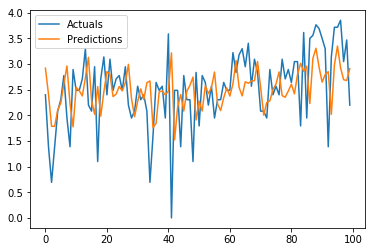

In [134]:
comp_df.head(100).plot()

In [141]:

# Make predictions on train data to see how it is performing against the test RMSE
y_pred_train = [train_X.shape[0]]
y_pred_train =lstm_model_no_ret.predict(train_X)
no_ret_rmsle = mean_squared_error(train_y, y_pred_train)
print('RMSE for final model on training data: %.3f' % no_ret_rmsle)

RMSE for model with no return feedback: 0.588


Our RMSE values for the final model are very close for both training and testing dataset confirming that there is no case of overfitting or underfitting.